In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import datetime
import gc
import warnings
import time
import csv
warnings.filterwarnings('ignore')

In [2]:
import theory
import matplotlib.ticker as mticker
import pylandau
from pylandau import langau
from importlib import reload
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.integrate import quad
theory = reload(theory)

In [12]:
def save_file(name):
    path = r'./data/' + name
    i = input(f"Are you sure you want to overwrite {path}?")
    if i == "yes":
        with open(r'./data/' + name, 'w', newline='') as save:
            writer = csv.writer(save)
            writer.writerow(es)
            writer.writerow(dedxs)
        print(f"saved to {path}.")

In [11]:
def read_from_saved(name):
    es, dedxs = [], []
    path = r'./data/' + name
    with open(path, 'r', newline='') as save:
        reader = csv.reader(save)
        es = [float(e) for e in next(reader)]
        dedxs = [float(dedx) for dedx in next(reader)]
    print(f'reading from {path}.')
    return es, dedxs

In [5]:
es, dedxs = read_from_saved('Analyzed_Data_Full.csv')
# %run Analyze.ipynb                             # Analyze the data from scratch

In [6]:
# Converts the read data to numpy data arrays and converts the energies
# which I assume is the total muon energy to kinetic energy
rest_e = theory.Mmu
es = np.array(es)
dedxs = np.asarray(dedxs)
es = es - (rest_e/1000)
bethe_ke = es > 0.1
es = es[bethe_ke]
dedxs = dedxs[bethe_ke]

### Plotting

In [7]:
def plot_raw():
    plt.figure()
    ax = plt.gca()
    ax.set_xlabel('Muon Energy (GeV)')
    ax.set_ylabel('Energy Loss (MeV/cm)')
    plt.plot(es, dedxs, '.')

In [8]:
max_e = 100 # np.max(es)
min_e = 0.1 # np.min(es)

def bin_data(num_bins=20):
    bin_edges = np.logspace(np.log10(min_e), np.log10(max_e), num_bins+1)
    bin_locs = np.digitize(es, bin_edges)

    binned_dedx = [[] for i in range(num_bins)]
    for i in range(len(bin_locs)):
        b = bin_locs[i]
        binned_dedx[b-1].append(dedxs[i])
    
    return bin_edges, binned_dedx

In [9]:
num_bins = 20
bin_edges, binned_dedx = bin_data()
e_bin_centers = [ 10**((np.log10(bin_edges[i+1]) + np.log10(bin_edges[i]))/2) for i in range(len(bin_edges)-1) ]

In [10]:
def generate_one_freq_vs_dedx(bd, num_bins):
    landau_bins = np.linspace(0, max(bd)+1, num_bins+1)
    bin_locs = np.digitize(bd, landau_bins)
    binned_counts = np.zeros(num_bins)

    for b in bin_locs:
        binned_counts[b-1] += 1
    
    dedx_bins = [ (landau_bins[j]+landau_bins[j+1])/2 for j in range(len(landau_bins)-1) ]

    mpv = dedx_bins[np.argmax(binned_counts)]
    
    return mpv, dedx_bins, binned_counts

In [11]:
def plot_one_freq_vs_dedx(i, dedx_bins, binned_counts):
    fig = plt.figure(figsize=(5,4))
    ax=plt.gca()
    plt.plot(dedx_bins, binned_counts, 'o', label='data')
    plt.xlabel("dE/dx (MeV/cm)", fontsize=10, fontweight='bold')
    plt.ylabel("Frequency",fontsize=10, fontweight='bold')
    plt.title(f"Energy Loss Distribution for muon energies [{bin_edges[i]:.2f},{bin_edges[i+1]:.2f}]GeV", fontsize=10, fontweight='bold')
    ax.set_xlim(0,7)
    return fig

In [12]:
''' 
Becuase of how the langau function is written, small values for eta are not supported, therefore the x values must
be scaled up by some arbitrary factor (sf). Here we choose a factor of 1000. By also scaling up the other arguments of
the langau_fit function, the returned fit values are physically accurate.
'''
sf = 10000

def langau_fit(dedxs, mpv, eta_L, sig_G, A):
    return langau(dedxs*sf, mpv*sf, eta_L*sf, sig_G*sf, A)

# The following lists are in the following order: mpv, eta_L, sigma_L, A
low_lims = [0, 1/sf, 0, 0]
up_lims = [5, 1, 1, 1000000]

In [13]:
def generate_fit(xdata, ydata):
    initial_guess = [2, 0.1, 0.1, max(ydata)]
    popt_L, pcov_L = curve_fit(langau_fit, xdata, ydata, p0=initial_guess, bounds=(low_lims, up_lims))
    
    fit_x_L = np.linspace(0, 7, 1000)
    fit_y_L = langau_fit(fit_x_L, *popt_L)
    
    return popt_L, fit_x_L, fit_y_L

In [54]:
def plot_fit(popt_L, xfit, yfit):
    label=f'Landau + Gaussian Fit:\nMPV={popt_L[0]:.2f}MeV/cm, \n$\eta$={popt_L[1]:.2f}, \n$\sigma$={popt_L[2]:.2f}, \n$A$={popt_L[3]:.0f}'
    plt.plot(xfit, yfit, label=label, ls='-')

### Problem
Calculating the average according to the Langau fit is giving results that are not consistent with what is expected. In the below code, we calculate the integral
$$\langle x\rangle =\int^\infty_{-\infty} xf_{LG}(x,\mu,\eta, \sigma)dx$$
where $x$ is the energy loss and $f_L$ is the normalized Landau distribution convolved with a Gaussian. In the code below, we multiply the langau provided by pylandau in order to normalize it (as this is not done natively, for some reason). However, calculating the integral gives results that are too high and also too varied.

In [55]:
def calculate_fit_av(mpv, eta, sigma, A):
    
    # There seems to be a mistake in the pylandau package. get_langau_pdf is not normalized,
    # however all that is necessary is to multiply by a factor of eta, it seems.
    def langau_pdf(x, m, e, s):
        return x * pylandau.get_langau_pdf(x, m, e, s) * eta 
    
    sol = quad(langau_pdf, -np.inf, np.inf, args=(mpv, eta, sigma), limit=1000)
    
    return sol[0]

In [56]:
def plot_freq_vs_dedx(plot_specific = None, num_bins = 1000, show = True, savefile = None):
    if plot_specific is None:
        fit_mpvs, fit_avs, data_mpvs = [], [], []
        i = 0
        for bd in binned_dedx:
            data_mpv, xdata, ydata = generate_one_freq_vs_dedx(bd, num_bins)
            fit_params, xfit, yfit = generate_fit(xdata, ydata)
            fit_mpv = fit_params[0]
            fit_av = calculate_fit_av(*fit_params)

            if show:
                fig = plot_one_freq_vs_dedx(i, xdata, ydata)
                plot_fit(fit_params, xfit, yfit)
                plt.legend()
                plt.show()
                if savefile is not None:
                    fig.savefig(os.getcwd() + r'/images/Full_Landau'+ str(i), bbox_inches = "tight")

            fit_mpvs.append(fit_mpv)
            fit_avs.append(fit_av)
            data_mpvs.append(data_mpv)
            i += 1
    else: 
        bd = binned_dedx[plot_specific]
        data_mpv, xdata, ydata = generate_one_freq_vs_dedx(bd, num_bins)
        fit_params, xfit, yfit = generate_fit(xdata, ydata)
        fit_mpv = fit_params[0]
        fit_av = calculate_fit_av(*fit_params)

        if show:
            fig = plot_one_freq_vs_dedx(plot_specific, xdata, ydata)
            plot_fit(fit_params, xfit, yfit)
            plt.legend()
            plt.show()
            if savefile is not None:
                fig.savefig(os.getcwd() + r'/'+ savefile, bbox_inches = "tight")

        fit_mpvs = fit_mpv
        fit_avs = fit_av
        data_mpvs = data_mpv

    return fit_mpvs, fit_avs, data_mpvs

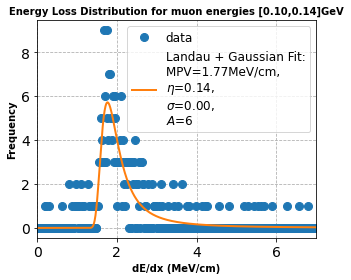

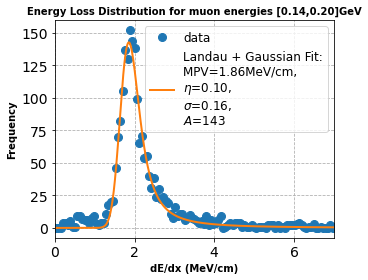

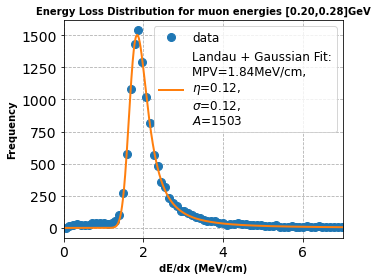

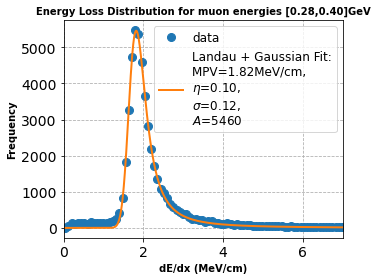

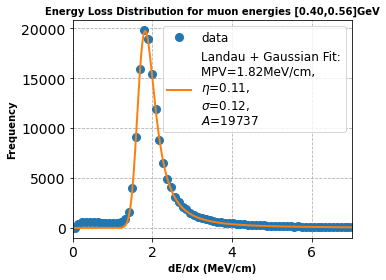

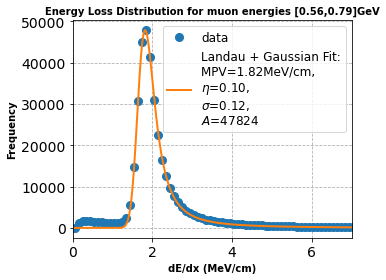

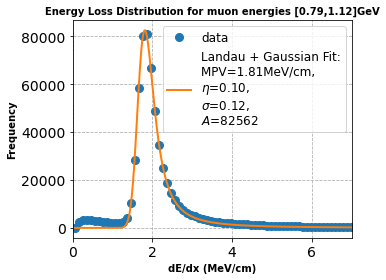

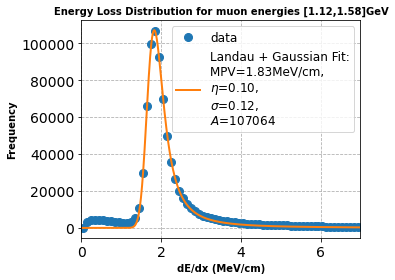

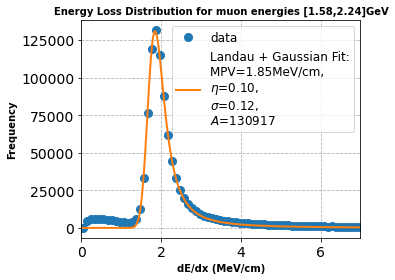

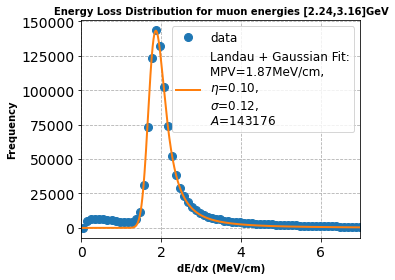

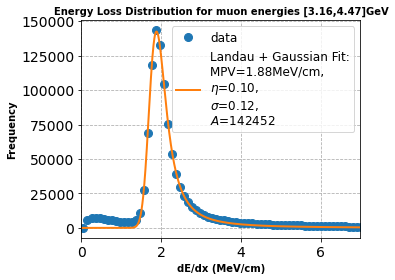

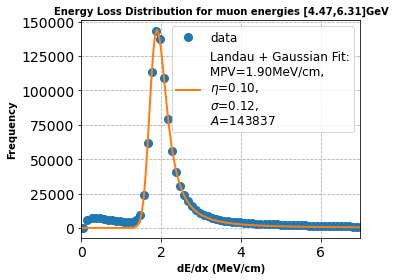

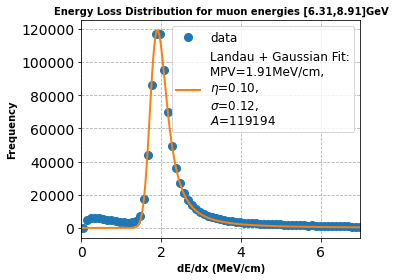

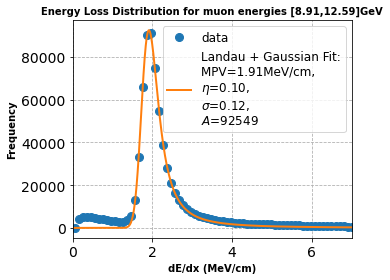

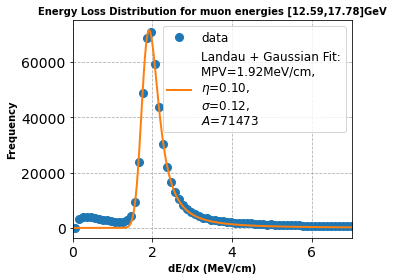

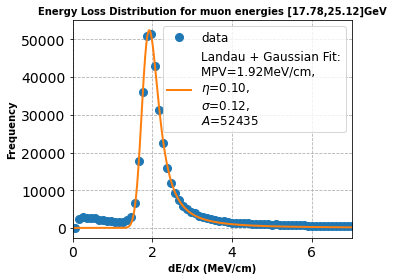

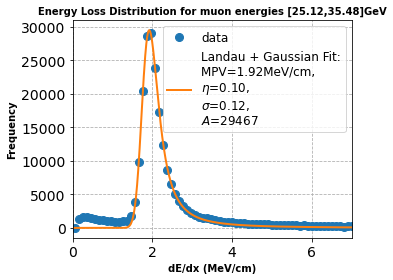

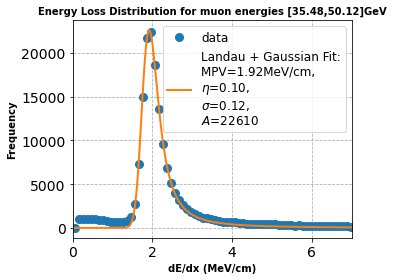

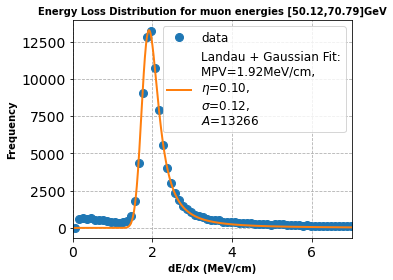

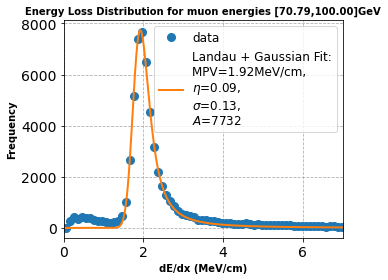

In [57]:
mpvs, avs, mpvs_data = plot_freq_vs_dedx(show=True)
avs_data = []
for b in binned_dedx:
    avs_data.append(np.mean(b))

In [18]:
avs_c = 'r'
mpvs_c = 'b'
true_ls = '-'
fit_ls = '--'
data_m = '^'
fit_m = 'o'

In [44]:
def plot_dedx_vs_e_data(with_fit_av=False, data_av=True, data_mpv=True, fit_mpv=True):    
    fig = plt.figure(figsize=(12,7))
    ax = plt.gca()
    if data_av:
        label = '$-$<dE/dx> from data'
        ax.errorbar(e_bin_centers, avs_data, label=label, color=avs_c, marker=data_m)
    if with_fit_av:
        label='$-$<dE/dx> from fit'
        ax.errorbar(e_bin_centers, avs, label=label, color=avs_c, marker=fit_m)
    if fit_mpv:
        label='$\Delta$p/dx from fits'
        ax.errorbar(e_bin_centers[1:], mpvs[1:], label=label, color=mpvs_c, marker=fit_m)
    if data_mpv:
        label='$\Delta$p/dx from data'
        ax.errorbar(e_bin_centers[1:], mpvs_data[1:], label=label, color=mpvs_c, marker=data_m, alpha=0.5)
    ax.set_xscale('log')
    ax.set_xlabel('Muon Kinetic Energy (GeV)')
    ax.set_ylabel('Energy Loss (MeV/cm)')
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    
    return fig, ax

## Fitting

In [91]:
plt.style.use('./eloss.mplstyle')

In [30]:
fit_es = np.logspace(np.log10(min_e), np.log10(max_e), 1000) # kinetic energy (GeV) xdata for the fits
fit_es_mev = fit_es * 1000
ke = fit_es_mev

bethe_dedx = theory.dedx(ke, rest_e)                         # Standard Bethe curve, no fit
bethe_dedx_no_delta = theory.dedx(ke, rest_e, dens=False)    # Same, but without density correction

ke_bin_centers = np.asarray(e_bin_centers)*1000              # simulated kinetic energy (GeV) xdata converted to (MeV)

In [89]:
def av_fit(ke, fit_prefac, mee):
    return fit_prefac * theory.dedx(ke, rest_e, I=mee*10**(-6))

popt_av, pcov_av = curve_fit(av_fit, ke_bin_centers, avs_data, p0=(1, 188), bounds=((0.5, 100), (2, 300)))

fit_av_dedxs = av_fit(ke, *popt_av)
print(popt_av)

[  0.90873826 100.        ]


In [33]:
def mpv_fit(ke, t):
    return theory.dpdx(ke, t, rest_e)
    
popt_mpv, pcov_mpv = curve_fit(mpv_fit, ke_bin_centers[1:], mpvs[1:], p0=2.5, bounds=(0,5))

fit_mpv_dedxs = mpv_fit(ke, *popt_mpv)

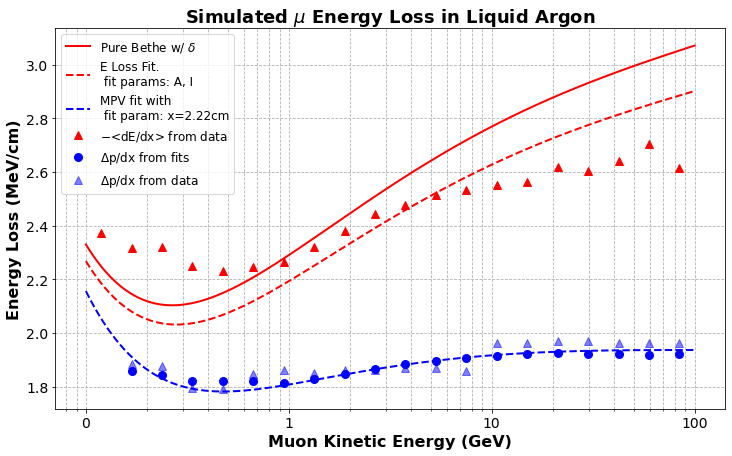

In [90]:
fig, ax = plot_dedx_vs_e_data()

ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_yscale('linear')

ax.plot(fit_es, bethe_dedx, label='Pure Bethe w/ $\delta$', color=avs_c, linestyle=true_ls)
ax.plot(fit_es, fit_av_dedxs, label=f'E Loss Fit. \n fit params: A, I', color=avs_c, ls=fit_ls)
ax.plot(fit_es, fit_mpv_dedxs, label=f'MPV fit with \n fit param: x={popt_mpv[0]:.2f}cm', color=mpvs_c, ls=fit_ls)
ax.set_title("Simulated $\mu$ Energy Loss in Liquid Argon")
ax.legend()
fig.show()

### Notes
The MPV data is much better fit to the theoretical curve than the average value data. The one parameter fit is, from a purely visual standpoint, much better than even the two parameter fit of the Bethe equation. Furthermore the two parameter fit of the Bethe equation indicates physically unreasonable values of the mean excitation energy and the prefacor multiplying the equation, both of which have been independently dertermined by experiment to differ significantly. Some potential fixes to the average value data are presented above, although I am not confiedent they will prove to fix the disagreement entirely.
- The data for the average energy loss is almost entirely lower than the expected energy loss according to the Bethe equation. This may suggest that there is some sort of confounding data that is not selected out during the selection cuts. Or perhaps even that the selection cuts are too stringent, and are removing too many high-energy loss events, pulling the average down at these higher energies.
- The MPV data can be improved by performing a fit to each of the Landau distributed energy losses per energy bin and finding the maximum according to that fit. 
    - I am not certain about using a least-squares fit on the Landau data, just because there are so many data points that do not contribute to the principal peak we are concerned with. I will test this when I can.he 
- To better fit the Bethe curve I could also calculate the average of the Landau distribution in the fits, although I believe the Landau pdf diverges, so the mean is undefined. I think this is also reason to suspect that the mean of a Landau distributed set of random variables will never converge, indeed, it tends to grow without bound with the sample size: https://drupal.star.bnl.gov/STAR/blog/lisa/mean-landau-distribution-undefined.
- Need to continue working on obtaining the average dedx from the fit Landaus, rather than continuing to use the raw data.
    - I am not certain how well this works in principal. Treating the Landau distribution as a pdf $f_L(x)$ and performing the integral to find the expectation value
    $$\langle x\rangle=\int^\infty_{-\infty} xf_L(x)dx$$
    gives entirely different results from computing the average via Bethe-Bloch equation (shown above). I do not know why.
    - Furthermore, the data points that result from this numerical integration to find the average value are also highly variable, which is probably due to the rather significant integration error associated with the numerical caluclation of this integral.
- The average value plot in the fitted case also does not follow the trend of the graph of the Bethe-Bloch curve. Instead, it appears to flatten out at high energies, which makes me think there might be an energy cutoff at play here. The effects of such a cutoff are outlined in chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fpdg.lbl.gov%2F2019%2Freviews%2Frpp2018-rev-passage-particles-matter.pdf&clen=2912706&chunk=true, section 33.2.8.

## MPV Residuals

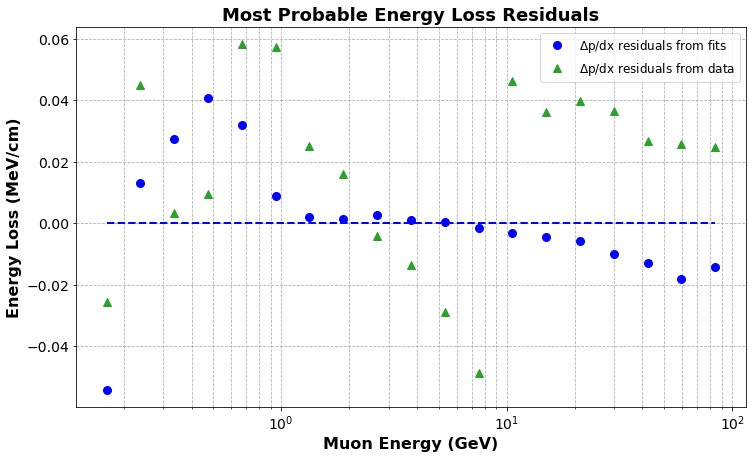

In [76]:
dp_cutoff = 1
expected_mpvs = np.array([ mpv_fit(x*1000, *popt_mpv) for x in e_bin_centers[dp_cutoff:] ])
zeros = np.zeros(len(e_bin_centers[dp_cutoff:]))

fig = plt.figure(figsize=(12,7))
ax = plt.gca()
ax.errorbar(e_bin_centers[dp_cutoff:], np.array(mpvs[dp_cutoff:])-expected_mpvs, fmt='o', label='$\Delta$p/dx residuals from fits', color = 'b')
ax.errorbar(e_bin_centers[dp_cutoff:], np.array(mpvs_data[dp_cutoff:])-expected_mpvs, fmt='o', label='$\Delta$p/dx residuals from data', color = 'tab:green', marker='^')
ax.plot(e_bin_centers[dp_cutoff:], zeros, color="b", ls='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel('Muon Energy (GeV)')
ax.set_ylabel('Energy Loss (MeV/cm)')
plt.title("Most Probable Energy Loss Residuals")
fig.show()

## MPV Bounds

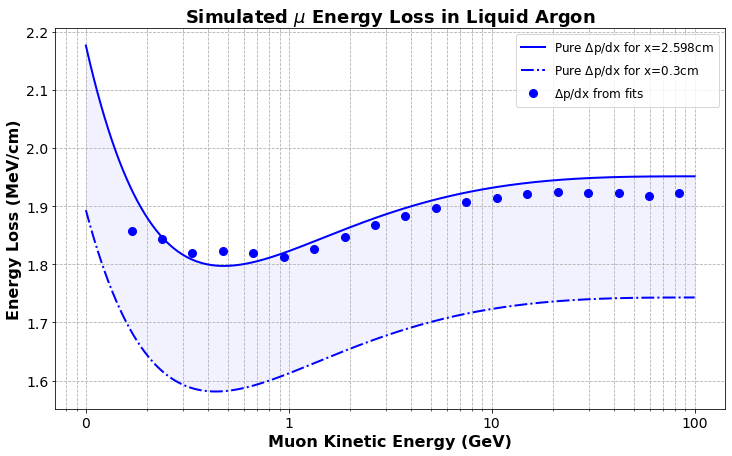

In [94]:
uplim_mpvs = [ mpv_fit(x*1000, 2.598) for x in fit_es ]
lolim_mpvs = [ mpv_fit(x*1000, 0.3) for x in fit_es ]

fig, ax = plot_dedx_vs_e_data(data_av=False, data_mpv=False)
ax.set_yscale('linear')

ax.plot(fit_es, uplim_mpvs, ls='-', color='b', label='Pure $\Delta$p/dx for x=2.598cm')
ax.plot(fit_es, lolim_mpvs, ls='-.', color='b', label='Pure $\Delta$p/dx for x=0.3cm')
ax.fill_between(fit_es, lolim_mpvs, uplim_mpvs, color='b', alpha=0.05)

ax.set_title("Simulated $\mu$ Energy Loss in Liquid Argon")
ax.legend()
fig.show()

## Restricted Average Energy Loss

In [98]:
def av_R0_fit(ke, wcut, prefac, mee):
    return theory.dedx_R(ke, rest_e, wcut, K=prefac, I=mee*10**(-6))
popt_av_R0, pcov_av_R0 = curve_fit(av_R0_fit, ke_bin_centers, avs_data, p0=(10, theory.K, 188), maxfev=10000) #bounds=((0,0.2,186*10**(-6)),(100,4,190*10**(-6))),maxfev=10000)


def av_R1_fit(ke, wcut):
    return theory.dedx_R(ke, rest_e, wcut)
popt_av_R1, pcov_av_R1 = curve_fit(av_R1_fit, ke_bin_centers, avs_data, p0=(0.1), maxfev=10000)


def av_R2_fit(ke, wcut, a, b):
    return theory.dedx_R(ke + a, rest_e, wcut) + b
popt_av_R2, pcov_av_R2 = curve_fit(av_R2_fit, ke_bin_centers, avs_data, p0=(0.1, 10, 1), maxfev=10000)


fit_av_R0_dedxs = av_R0_fit(ke, *popt_av_R0)
fit_av_R1_dedxs = av_R1_fit(ke, *popt_av_R1)
fit_av_R2_dedxs = av_R2_fit(ke, *popt_av_R2)

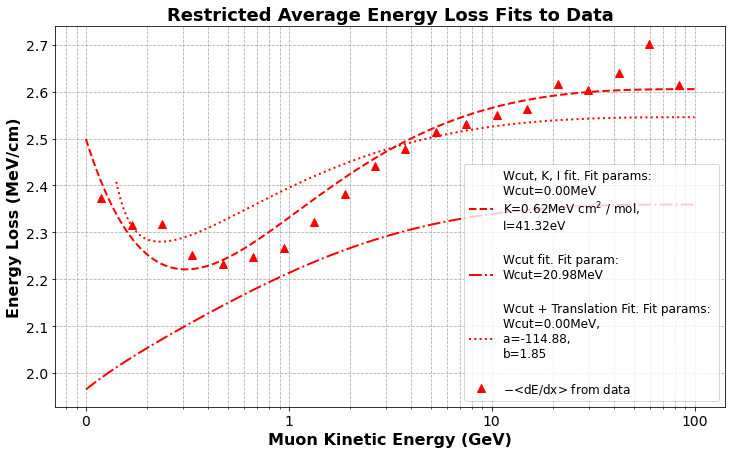

In [120]:
fig, ax = plot_dedx_vs_e_data(data_mpv=False, fit_mpv=False) 

ax.plot(fit_es, fit_av_R0_dedxs, label=f'Wcut, K, I fit. Fit params: \nWcut={popt_av_R0[0]:.2f}MeV \nK={popt_av_R0[1]:.2f}MeV cm$^2$ / mol, \nI={popt_av_R0[2]:.2f}eV\n', color=avs_c, ls='--')
ax.plot(fit_es, fit_av_R1_dedxs, label=f'Wcut fit. Fit param: \nWcut={popt_av_R1[0]:.2f}MeV\n', color=avs_c, ls='-.')
ax.plot(fit_es[50:], fit_av_R2_dedxs[50:], label=f'Wcut + Translation Fit. Fit params: \nWcut={popt_av_R2[0]:.2f}MeV, \na={popt_av_R2[1]:.2f}, \nb={popt_av_R2[2]:.2f}\n', color=avs_c, ls=':')
ax.set_title("Restricted Average Energy Loss Fits to Data")
ax.legend()

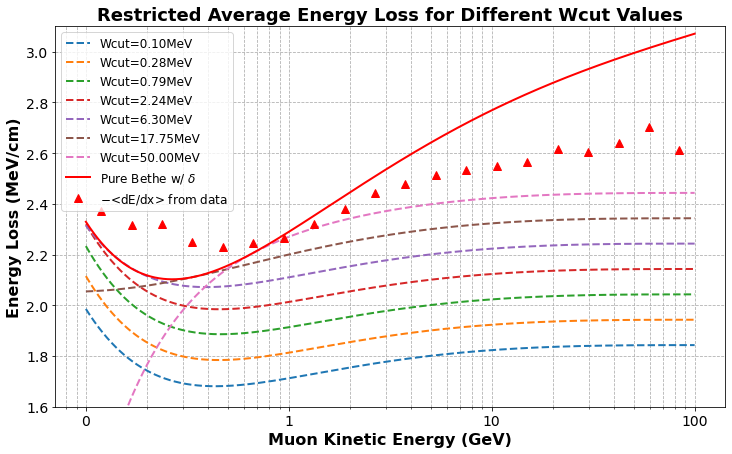

In [125]:
fig, ax = plot_dedx_vs_e_data(data_mpv=False, fit_mpv=False)

min_wcut = 0.1
max_wcut = 50
num_plotted = 7
wcuts = np.logspace(np.log10(min_wcut), np.log10(max_wcut), num_plotted)
for wcut in wcuts:
    av_dedxs_R = theory.dedx_R(ke, rest_e, wcut)
    label=f'Wcut={wcut:.2f}MeV'
    ax.plot(fit_es, av_dedxs_R, label=label, ls=fit_ls)

ax.plot(fit_es, bethe_dedx, label='Pure Bethe w/ $\delta$', color=avs_c, linestyle=true_ls)
ax.set_title("Restricted Average Energy Loss for Different Wcut Values")
ax.legend()
ax.set_ylim(1.6, 3.1)
fig.show()

### Notes on Restricted Average Energy Loss
The equation for modelling the restricted average energy loss is differs somewhat from the data. This difference was present in the Bethe equation fit, but it was just less apparent than the deviations at the high end.
- It may be the case that I am not selecting out high energy outlier events correctly from the data. This might bring up the average energy loss much higher above where it should be, so I will need to check the data more thouroughly to see if there are any such confounding events to get rid of.
- Another consideration is that the location of the minimum ionization value differs in the wcut fits from the data. The location of the minimum varies very little with wcut, so this suggests there is some other problem with the data. I have already subtracted off the rest energy of the muon, so in theory we shold be working with solely the muon kinetic energy here, but there may be something I missed. It might also be the case that the backtracked energy of the simulated muons is already the kinetic energy, but I believe this would shift the minimum location the other way, which is not good.